In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc
from modified_spectral_method import *
from modified_louvain_method import *
from proxy_methods_final import *
import cvxpy as cp
import copy
import matplotlib.pyplot as plt

/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
metadata = pd.read_csv('data/metadata.csv')
reshaped_data = pd.read_csv('data/reshaped_data.csv')

In [3]:
reshaped_data

,Date,AAUK,ABE,ABHLTD,ACAFP,ACAFP-CIB,ACCOR,ACEA,ADIG,AEGON,...,VLVY-Treasury,VOD,VW,WEINBG,WENL,WINDAQ,WOLKLU,WPPGRP-2005,YORPOW,ZINCO
0,2010-09-14 00:00:00,179.666667,252.500000,248.225806,123.000000,120.065811,133.333333,78.555937,89.086828,165.166667,...,143.703161,78.653530,98.287293,312.144549,427.868852,550.204082,68.833333,132.833333,51.549539,99.000000
1,2010-09-15 00:00:00,175.666667,253.553505,250.322581,124.166667,125.346061,133.333333,78.674166,89.746817,166.500000,...,137.526004,80.870588,100.372671,315.809361,422.270270,542.040816,69.011765,132.275229,51.615352,99.500000
2,2010-09-16 00:00:00,174.666667,253.478186,253.658537,122.000000,122.069897,129.833333,77.415326,89.751163,163.333333,...,167.919307,81.562500,97.666667,316.897843,414.516129,556.744186,68.112308,130.788991,51.384026,100.822781
3,2010-09-17 00:00:00,169.500000,253.417889,249.268293,124.000000,122.399586,122.666667,74.098890,89.751278,159.333333,...,175.640643,84.169014,97.225673,317.472295,410.655738,546.081081,69.061224,129.698630,51.399602,95.131222
4,2010-09-20 00:00:00,171.833333,250.460282,254.047183,129.166667,122.810584,126.750000,76.515151,89.060149,162.666667,...,134.164354,81.484536,96.066253,316.516258,415.573770,550.378378,68.108108,132.833333,51.536094,101.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,2020-04-28 00:00:00,176.334600,120.474900,169.815900,54.959700,52.345400,239.073900,88.206400,81.069800,133.937300,...,76.779800,91.104700,164.174700,368.918800,95.373100,41.281800,31.033200,155.939900,75.349900,42.449000
2511,2020-04-29 00:00:00,176.605000,120.885000,170.533200,53.745800,51.238500,237.998100,88.213700,81.057500,134.345000,...,76.791500,90.488700,160.994100,370.851600,95.206200,41.330800,30.780900,148.449200,75.359500,40.402900
2512,2020-04-30 00:00:00,166.690600,120.516700,169.772900,52.172800,50.434200,232.724500,88.213400,81.036100,132.761600,...,76.404700,85.346200,158.997200,369.247500,91.609200,41.309200,29.594200,144.818300,75.353800,39.661100
2513,2020-05-01 00:00:00,166.130300,121.650700,171.038900,54.654500,48.042600,234.903000,88.228100,81.044200,133.690100,...,76.034600,87.044200,165.180000,374.743400,99.308600,41.496100,29.636700,146.774900,75.364800,42.251900


### (i)
Remove all ‘CCC-’ and ‘D’-rated entities since their
spreads contain a large percentage of outliers which
makes our analysis inaccurate. Furthermore, for these
close-to-default entities, banks might decide to use a special methodology instead of the standard proxy method.

In [4]:
# Remove all ratings below CCC- ( AverageRating > 19 )
filtered_metadata = metadata[metadata['AverageRating'] < 19]

# Extract the tickers from the metadata
valid_tickers = filtered_metadata['Ticker']

# Filter the reshaped_data to only keep columns with tickers in metadata, including the "Date" column
filtered_reshaped_data = reshaped_data[['Date'] + [col for col in reshaped_data.columns if col in valid_tickers.values]]

In [5]:
filtered_metadata

,Ticker,ShortName,Sector,Region,Country,AverageRating
0,AAUK,Anglo Amern plc,Basic Materials,Europe,United Kingdom,14
1,ABE,Abertis Infraestructuras SA,Industrials,Europe,Spain,9
2,ABHLTD,Alliance Boots Hldgs Ltd,Consumer Services,Europe,United Kingdom,10
3,ACAFP,Cr Agricole SA,Financials,Europe,France,5
4,ACAFP-CIB,Cr Agricole Corporate and Invt Bk,Financials,Europe,France,10
...,...,...,...,...,...,...
313,WINDAQ,Wind Acquisition Fin SA,Financials,Europe,Luxembourg,17
314,WOLKLU,Wolters Kluwer N V,Consumer Services,Europe,Netherlands,9
315,WPPGRP-2005,WPP 2005 Ltd,Consumer Services,Europe,United Kingdom,17
316,YORPOW,Yorkshire Pwr Gp Ltd,Utilities,Europe,United Kingdom,10


In [6]:
filtered_reshaped_data.shape

(2515, 317)

In [7]:
filtered_reshaped_data

,Date,AAUK,ABE,ABHLTD,ACAFP,ACAFP-CIB,ACCOR,ACEA,ADIG,AEGON,...,VLVY-Treasury,VOD,VW,WEINBG,WENL,WINDAQ,WOLKLU,WPPGRP-2005,YORPOW,ZINCO
0,2010-09-14 00:00:00,179.666667,252.500000,248.225806,123.000000,120.065811,133.333333,78.555937,89.086828,165.166667,...,143.703161,78.653530,98.287293,312.144549,427.868852,550.204082,68.833333,132.833333,51.549539,99.000000
1,2010-09-15 00:00:00,175.666667,253.553505,250.322581,124.166667,125.346061,133.333333,78.674166,89.746817,166.500000,...,137.526004,80.870588,100.372671,315.809361,422.270270,542.040816,69.011765,132.275229,51.615352,99.500000
2,2010-09-16 00:00:00,174.666667,253.478186,253.658537,122.000000,122.069897,129.833333,77.415326,89.751163,163.333333,...,167.919307,81.562500,97.666667,316.897843,414.516129,556.744186,68.112308,130.788991,51.384026,100.822781
3,2010-09-17 00:00:00,169.500000,253.417889,249.268293,124.000000,122.399586,122.666667,74.098890,89.751278,159.333333,...,175.640643,84.169014,97.225673,317.472295,410.655738,546.081081,69.061224,129.698630,51.399602,95.131222
4,2010-09-20 00:00:00,171.833333,250.460282,254.047183,129.166667,122.810584,126.750000,76.515151,89.060149,162.666667,...,134.164354,81.484536,96.066253,316.516258,415.573770,550.378378,68.108108,132.833333,51.536094,101.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,2020-04-28 00:00:00,176.334600,120.474900,169.815900,54.959700,52.345400,239.073900,88.206400,81.069800,133.937300,...,76.779800,91.104700,164.174700,368.918800,95.373100,41.281800,31.033200,155.939900,75.349900,42.449000
2511,2020-04-29 00:00:00,176.605000,120.885000,170.533200,53.745800,51.238500,237.998100,88.213700,81.057500,134.345000,...,76.791500,90.488700,160.994100,370.851600,95.206200,41.330800,30.780900,148.449200,75.359500,40.402900
2512,2020-04-30 00:00:00,166.690600,120.516700,169.772900,52.172800,50.434200,232.724500,88.213400,81.036100,132.761600,...,76.404700,85.346200,158.997200,369.247500,91.609200,41.309200,29.594200,144.818300,75.353800,39.661100
2513,2020-05-01 00:00:00,166.130300,121.650700,171.038900,54.654500,48.042600,234.903000,88.228100,81.044200,133.690100,...,76.034600,87.044200,165.180000,374.743400,99.308600,41.496100,29.636700,146.774900,75.364800,42.251900


### (iv)
Remove the quotes from the ‘Government’ sector since
sovereign CDS’s have been studied independently in
the literature

In [8]:
# Remove "Government" sector tickers from filtered_metadata
filtered_metadata = filtered_metadata[filtered_metadata['Sector'] != 'Government']

# Update the list of valid tickers
valid_tickers = filtered_metadata['Ticker']

# Filter the reshaped_data again to only keep columns with tickers in the updated metadata, including the "Date" column
filtered_reshaped_data = reshaped_data[['Date'] + [col for col in reshaped_data.columns if col in valid_tickers.values]]


In [9]:
filtered_reshaped_data.shape

(2515, 297)

In [10]:
filtered_metadata_gov = filtered_metadata[filtered_metadata['Sector'] == 'Government']
filtered_metadata_tickers = filtered_metadata_gov['Ticker']
filtered_metadata_gov

,Ticker,ShortName,Sector,Region,Country,AverageRating


### (vii)
Remove quotes for entities which are above 1000 basis
points. This allows us to have a more accurate estimate of
errors in proxying, and similar to ‘CCC-’ and ‘D’-rated
entities, banks might decide to use a special methodology instead of the standard proxy method for these
entities.

In [11]:
# Remove quotes for entities with values above 1000 basis points in the reshaped data
# Excluding the 'Date' column, apply the filtering condition
filtered_reshaped_data = filtered_reshaped_data.copy()
for column in filtered_reshaped_data.columns[1:]:  # Exclude 'Date'
    filtered_reshaped_data[column] = filtered_reshaped_data[column].where(filtered_reshaped_data[column] < 1000)
    
# Count the total number of NaN values in the filtered dataset
# ( Values above 1000 are turned into NaNs )
nan_count = filtered_reshaped_data.isna().sum().sum()

nan_count

6426

In [12]:
# Remove columns that contain any NaN values
filtered_reshaped_data = filtered_reshaped_data.dropna(axis=1)

In [13]:
filtered_reshaped_data.shape

(2515, 270)

In [14]:
filtered_metadata['Sector'].value_counts()

Sector
Financials            87
Consumer Services     41
Industrials           37
Utilities             34
Consumer Goods        34
Basic Materials       26
Telecommunications    17
Health Care            7
Oil & Gas              7
Technology             6
Name: count, dtype: int64

### Remove ticker that was causing issue with community detection

In [15]:
filtered_reshaped_data = filtered_reshaped_data.drop(columns=['IFX-HldgBV'])

### Align columns in meta data and euro data standardised with filtered_reshaped_data

In [16]:
# Extract the list of tickers from the final filtered reshaped data (excluding the 'Date' column)
final_tickers = set(filtered_reshaped_data.columns[1:])

# Filter the metadata to include only tickers that are in the final reshaped data
filtered_metadata_final = filtered_metadata[filtered_metadata['Ticker'].isin(final_tickers)]

# Display the filtered metadata
print(filtered_metadata_final)


          Ticker                          ShortName             Sector  \
1            ABE        Abertis Infraestructuras SA        Industrials   
2         ABHLTD           Alliance Boots Hldgs Ltd  Consumer Services   
3          ACAFP                     Cr Agricole SA         Financials   
4      ACAFP-CIB  Cr Agricole Corporate and Invt Bk         Financials   
5          ACCOR                              ACCOR  Consumer Services   
..           ...                                ...                ...   
312         WENL                             WENDEL         Financials   
314       WOLKLU                 Wolters Kluwer N V  Consumer Services   
315  WPPGRP-2005                       WPP 2005 Ltd  Consumer Services   
316       YORPOW               Yorkshire Pwr Gp Ltd          Utilities   
317        ZINCO                  Zurich Ins Co Ltd         Financials   

     Region         Country  AverageRating  
1    Europe           Spain              9  
2    Europe  United K

In [17]:
#Adjuts columns for EU data standardised returns

standardized_returns = pd.read_csv('data/eur_data_standardized_returns.csv')

#Filter standardized returns to only include tickers that are in prices_data

standardized_returns = standardized_returns[standardized_returns.columns[standardized_returns.columns.isin(filtered_reshaped_data.columns)]]

### Save data before aggregation
---

In [18]:
# Export the final filtered metadata to a CSV file
filtered_metadata_final.to_csv('data/new_metadata_before_aggregation.csv', index=False)

# # Export the final filtered reshaped data to a CSV file
# filtered_reshaped_data.to_csv('data/new_reshaped_data_before_aggregation.csv', index=False)

# standardized_returns.to_csv('data/new_eur_data_standardized_returns_before_aggregation.csv', index=False)

# Bucket Aggregation
---

###
Redefine the sectors Basic Materials, Consumer Services, Energy, Technology, Telecommunication services
and Industrials as Cyclical, and Consumer Goods, Health
care and Utilities as Non Cyclical

In [19]:
# Get counts of unique intersections of Sector, Country and AverageRating in the filtered metadata

grouped_counts = filtered_metadata_final.groupby(['Sector', 'Country', 'AverageRating']).size().reset_index(name='Count')

grouped_counts


,Sector,Country,AverageRating,Count
0,Basic Materials,Austria,12,1
1,Basic Materials,Belgium,9,1
2,Basic Materials,Finland,10,2
3,Basic Materials,France,10,1
4,Basic Materials,Germany,6,2
...,...,...,...,...
148,Utilities,United Kingdom,7,1
149,Utilities,United Kingdom,8,1
150,Utilities,United Kingdom,9,1
151,Utilities,United Kingdom,10,8


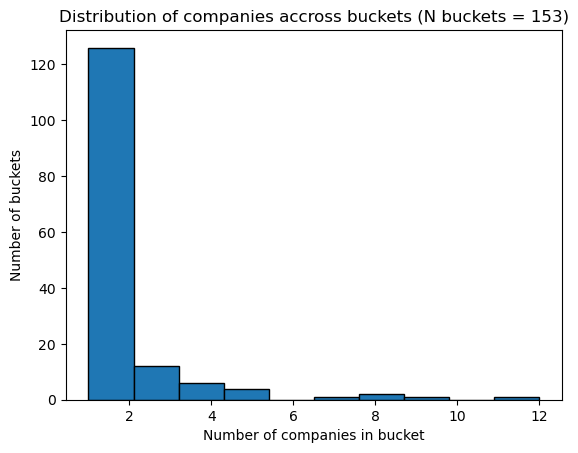

In [20]:
plt.hist(grouped_counts['Count'], bins=10, edgecolor='black')
plt.title(f'Distribution of companies accross buckets (N buckets = {len(grouped_counts)})')
plt.xlabel('Number of companies in bucket')
plt.ylabel('Number of buckets')
plt.show()

# Grouping sectors

In [21]:
# Redefine sectors in metadata
cyclical_sectors = ['Basic Materials', 'Consumer Services', 'Energy', 'Oil & Gas', 'Technology', 
                    'Telecommunications', 'Industrials']
non_cyclical_sectors = ['Consumer Goods', 'Health Care', 'Utilities']

filtered_metadata_final['Sector'] = np.where(filtered_metadata_final['Sector'].isin(cyclical_sectors), 'Cyclical', filtered_metadata_final['Sector'])
filtered_metadata_final['Sector'] = np.where(filtered_metadata_final['Sector'].isin(non_cyclical_sectors), 'Non Cyclical', filtered_metadata_final['Sector'])

# Display the updated metadata DataFrame
filtered_metadata_final


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_89023/3868294891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata_final['Sector'] = np.where(filtered_metadata_final['Sector'].isin(cyclical_sectors), 'Cyclical', filtered_metadata_final['Sector'])
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_89023/3868294891.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata_final['Sector'] = np.where(filtered_metadata_final['Sector'].isin(non_cyclical_sectors),

,Ticker,ShortName,Sector,Region,Country,AverageRating
1,ABE,Abertis Infraestructuras SA,Cyclical,Europe,Spain,9
2,ABHLTD,Alliance Boots Hldgs Ltd,Cyclical,Europe,United Kingdom,10
3,ACAFP,Cr Agricole SA,Financials,Europe,France,5
4,ACAFP-CIB,Cr Agricole Corporate and Invt Bk,Financials,Europe,France,10
5,ACCOR,ACCOR,Cyclical,Europe,France,10
...,...,...,...,...,...,...
312,WENL,WENDEL,Financials,Europe,France,10
314,WOLKLU,Wolters Kluwer N V,Cyclical,Europe,Netherlands,9
315,WPPGRP-2005,WPP 2005 Ltd,Cyclical,Europe,United Kingdom,17
316,YORPOW,Yorkshire Pwr Gp Ltd,Non Cyclical,Europe,United Kingdom,10


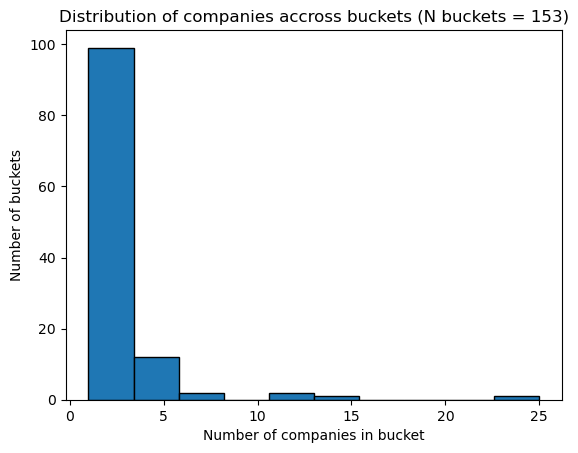

In [22]:
# Get counts of unique intersections of Sector, Country and AverageRating in the filtered metadata

grouped_counts_after_aggregation  = filtered_metadata_final.groupby(['Sector', 'Country', 'AverageRating']).size().reset_index(name='Count')

plt.hist(grouped_counts_after_aggregation['Count'], bins=10, edgecolor='black')
plt.title(f'Distribution of companies accross buckets (N buckets = {len(grouped_counts)})')
plt.xlabel('Number of companies in bucket')
plt.ylabel('Number of buckets')
plt.show()


In [23]:
average_rating  = filtered_metadata_final['AverageRating']

<BarContainer object of 16 artists>

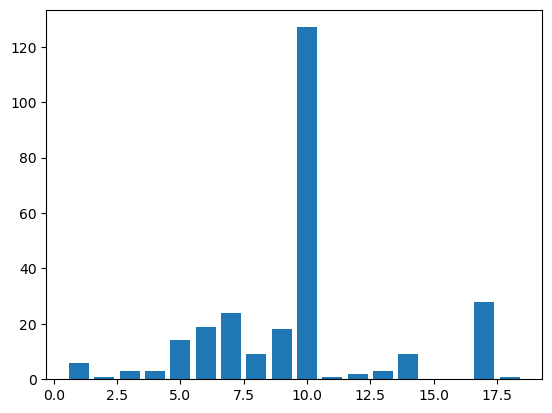

In [24]:
plt.bar(average_rating.value_counts().index, average_rating.value_counts().values)

# Grouping ratings

In [25]:


# Display the updated metadata DataFrame
filtered_metadata_final

def rating_to_label(rating):
    if 1 <= rating <= 7:
        return "low"
    elif 8 <= rating <= 14:
        return "medium"
    elif rating >= 15:
        return "high"
    else:
        return "unknown"  # Just in case there's an unexpected value

# Replace values in the AverageRating column
filtered_metadata_final['AverageRating'] = filtered_metadata_final['AverageRating'].apply(rating_to_label)


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_89023/3603783896.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata_final['AverageRating'] = filtered_metadata_final['AverageRating'].apply(rating_to_label)


In [26]:
filtered_metadata_final

,Ticker,ShortName,Sector,Region,Country,AverageRating
1,ABE,Abertis Infraestructuras SA,Cyclical,Europe,Spain,medium
2,ABHLTD,Alliance Boots Hldgs Ltd,Cyclical,Europe,United Kingdom,medium
3,ACAFP,Cr Agricole SA,Financials,Europe,France,low
4,ACAFP-CIB,Cr Agricole Corporate and Invt Bk,Financials,Europe,France,medium
5,ACCOR,ACCOR,Cyclical,Europe,France,medium
...,...,...,...,...,...,...
312,WENL,WENDEL,Financials,Europe,France,medium
314,WOLKLU,Wolters Kluwer N V,Cyclical,Europe,Netherlands,medium
315,WPPGRP-2005,WPP 2005 Ltd,Cyclical,Europe,United Kingdom,high
316,YORPOW,Yorkshire Pwr Gp Ltd,Non Cyclical,Europe,United Kingdom,medium


<BarContainer object of 3 artists>

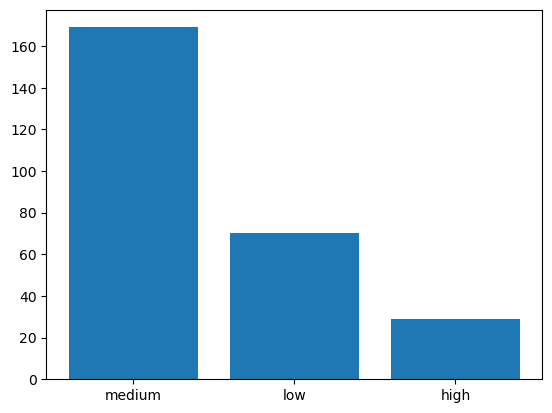

In [27]:
#Plot distribution of ratings after aggregation

average_rating  = filtered_metadata_final['AverageRating']

plt.bar(average_rating.value_counts().index, average_rating.value_counts().values)

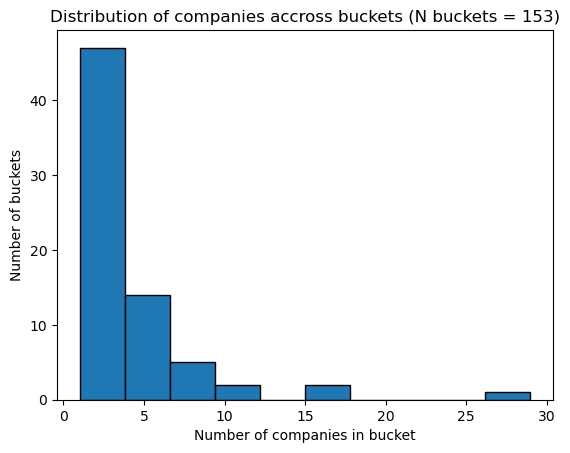

In [28]:

# Assuming your DataFrame is stored in a variable called `df`
grouped_counts_after_aggregation  = filtered_metadata_final.groupby(['Sector', 'Country', 'AverageRating']).size().reset_index(name='Count')

plt.hist(grouped_counts_after_aggregation['Count'], bins=10, edgecolor='black')
plt.title(f'Distribution of companies accross buckets (N buckets = {len(grouped_counts)})')
plt.xlabel('Number of companies in bucket')
plt.ylabel('Number of buckets')
plt.show()

### Save data after aggregation
---

In [29]:
# Export the final filtered metadata to a CSV file
filtered_metadata_final.to_csv('data/new_metadata_after_aggregation.csv', index=False)

# Export the final filtered reshaped data to a CSV file
filtered_reshaped_data.to_csv('data/new_reshaped_data.csv', index=False)

standardized_returns.to_csv('data/new_eur_data_standardized_returns.csv', index=False)